In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os
import numpy as np
import datasets

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

/home/user33/.conda/envs/rmt/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('..')
from utils.reasoning import make_segment, split_cot
from torch.nn.utils.rnn import pad_sequence

from modeling_rmt.language_modeling import MemoryCell
from modeling_rmt.experimental import RecurrentWrapperNoSegmentation

In [3]:
# model_name = "HuggingFaceTB/SmolLM2-135M"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [4]:
class Holder:
    def __init__(self):
        pass
args = Holder()
# args.use_cot = False
args.num_mem_tokens = None
args.task_name = 'gsm8k'
# args.task_name = 'multiplication'

In [5]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [6]:
ans = tokenizer.encode('<empty_output>')

In [7]:
ans

[16]

In [8]:
tokenizer.eos_token_id

0

In [9]:
tokenizer.bos_token_id, tokenizer.pad_token_id, tokenizer.eos_token_id

(0, None, 0)

In [10]:
ans = tokenizer.batch_encode_plus(['!!!!', '????', '////'])
ans

{'input_ids': [[36689], [16693, 16693], [24556]], 'attention_mask': [[1], [1, 1], [1]]}

In [11]:
tokenizer.decode(13896)

'Mult'

In [13]:
# id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
# think = tokenizer.encode("<issue_start>")
# ans = tokenizer.encode("<issue_closed>")
# reason_token = tokenizer.encode("<empty_output>") ### not needed
# bos = [tokenizer.bos_token_id]
# eos = [tokenizer.eos_token_id]
# if 'gsm8k' in args.task_name:
#     delim = ">> <<"
# elif 'multiplication' in args.task_name:
#     delim = ' + '
# else:
#     raise NotImplementedError(f"Unknown task name {args.task_name}")

# def collate_fn(batch):
#     # first, we segment each sample into task, cot steps and labels
#     segments_batch = []
#     for sample in batch:
#         task, lab, cot = sample['task'], sample['labels'], sample['cot']
#         task_tokens = tokenizer.encode(task, add_special_tokens=False)
#         labels_tokens = tokenizer.encode(lab, add_special_tokens=False)
#         cot_segments = split_cot(cot, by=delim)
#         cot_segment_tokens = tokenizer.batch_encode_plus(cot_segments, add_special_tokens=False)['input_ids']

#         segments = []
#         segments.append(make_segment(bos + task_tokens + think, loss=False))
#         for segment in cot_segment_tokens[:-1]:
#             segments.append(make_segment(bos + segment + think, loss=True))
#         segments.append(make_segment(bos + cot_segment_tokens[-1] + ans, loss=True))

#         segments.append(make_segment(bos + labels_tokens + eos, loss=True))
#         segments_batch.append(segments)

#     # if some samples have less segments than others, we pad them with empty segments
#     num_segments = max(len(segments) for segments in segments_batch)
#     for segments in segments_batch:
#         if len(segments) < num_segments:
#             segments.extend([make_segment(eos, loss=False)] * (num_segments - len(segments)))

#     # prepare segments for the whole batch
#     batch_segments = []
#     for i in range(num_segments):
#         input_ids = [s[i]['input_ids'] for s in segments_batch]
#         attention_mask = [s[i]['attention_mask'] for s in segments_batch]
#         labels = [s[i]['labels'] for s in segments_batch]
#         labels_mask = [s[i]['labels_mask'] for s in segments_batch]

#         input_ids = pad_sequence(input_ids, batch_first=True, padding_value=id_pad_value)
#         attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
#         labels = pad_sequence(labels, batch_first=True, padding_value=-100)
#         labels_mask = pad_sequence(labels_mask, batch_first=True, padding_value=False)

#         batch_segment = {'input_ids': input_ids,
#                             'attention_mask': attention_mask,
#                             'labels_mask': labels_mask,
#                             'labels': labels
#                             }
#         batch_segments.append(batch_segment)
#     full_labels = torch.cat([s['labels'] for s in batch_segments], dim=1)
#     return {"segments": batch_segments, 'labels': full_labels}


In [5]:
id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
think = tokenizer.encode('????')
ans = tokenizer.encode('!!!!')
eos = [tokenizer.eos_token_id]
if 'gsm8k' in args.task_name:
    delim = ">> <<"
elif 'multiplication' in args.task_name:
    delim = ' + '
else:
    raise NotImplementedError(f"Unknown task name {args.task_name}")

def collate_fn(batch):
    # first, we segment each sample into task, cot steps and labels
    segments_batch = []
    for sample in batch:
        task, lab, cot = sample['task'], sample['labels'], sample['cot']
        task_tokens = tokenizer.encode(task, add_special_tokens=False)
        labels_tokens = tokenizer.encode(lab, add_special_tokens=False)
        cot_segments = split_cot(cot, by=delim)
        cot_segment_tokens = tokenizer.batch_encode_plus(cot_segments, add_special_tokens=False)['input_ids']

        # latent_reasoning_segment = tokenizer.batch_encode_plus(
        #     [reasoning_token]*text_seq_len, add_special_tokens=False
        # )['input_ids']

        segments = []
        segments.append(make_segment(task_tokens + think, loss=False))
        for segment in cot_segment_tokens[:-1]:
            segments.append(make_segment(segment + think, loss=True))
        segments.append(make_segment(cot_segment_tokens[-1] + ans, loss=True))

        segments.append(make_segment(labels_tokens + eos, loss=True))
        segments_batch.append(segments)

    # if some samples have less segments than others, we pad them with empty segments
    num_segments = max(len(segments) for segments in segments_batch)
    for segments in segments_batch:
        if len(segments) < num_segments:
            segments.extend([make_segment(eos, loss=False)] * (num_segments - len(segments)))

    # prepare segments for the whole batch
    batch_segments = []
    for i in range(num_segments):
        input_ids = [s[i]['input_ids'] for s in segments_batch]
        attention_mask = [s[i]['attention_mask'] for s in segments_batch]
        labels = [s[i]['labels'] for s in segments_batch]
        labels_mask = [s[i]['labels_mask'] for s in segments_batch]

        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=id_pad_value)
        attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
        labels = pad_sequence(labels, batch_first=True, padding_value=-100)
        labels_mask = pad_sequence(labels_mask, batch_first=True, padding_value=False)

        batch_segment = {'input_ids': input_ids,
                         'attention_mask': attention_mask,
                         'labels_mask': labels_mask,
                         'labels': labels
                         }
        batch_segments.append(batch_segment)
    full_labels = torch.cat([s['labels'] for s in batch_segments], dim=1)
    return {"segments": batch_segments, 'labels': full_labels}

In [6]:
dataset = 'booydar/gsm8k'
# dataset = 'booydar/multiplication_4x4'
train_dataset = datasets.load_dataset(dataset, split='train')
valid_dataset = datasets.load_dataset(dataset, split='valid')

In [7]:
tokenizer.encode("hello world")

[31373, 995]

In [ ]:
train_dataset[0]["task"]
task_length = [len(tokenizer.encode(train_dataset[i]["task"])) for i in range(len(train_dataset))]

In [30]:
import numpy as np

task_length = np.array(task_length)

In [31]:
print(np.mean(task_length), np.median(task_length), np.max(task_length))

46.812425250896986 45.0 223


In [83]:
import matplotlib.pyplot as plt

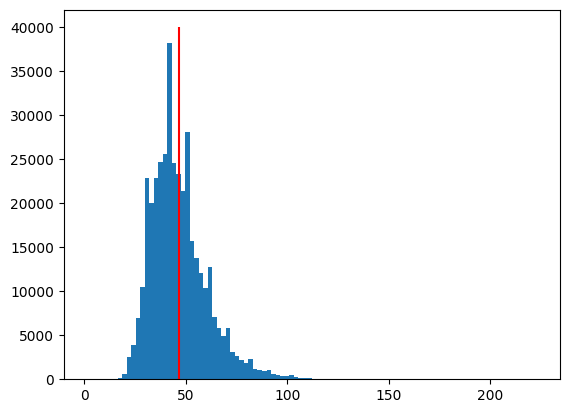

In [37]:
plt.hist(task_length, bins=100)
plt.vlines(np.mean(task_length), 0, 40000, color="red")
plt.show()

In [81]:
cot_length = [train_dataset[i]["cot_len"] for i in range(len(train_dataset))]

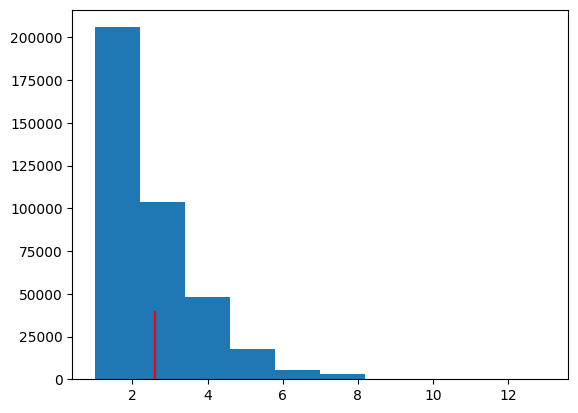

In [85]:
plt.hist(cot_length, bins=10)
plt.vlines(np.mean(cot_length), 0, 40000, color="red")
plt.show()

In [16]:
valid_dataset[0]

{'task': 'John cuts his grass to 2 inches.  It grows .5 inches per month.  When it gets to 4 inches he cuts it back down to 2 inches.  It cost $100 to get his grass cut.  How much does he pay per year?',
 'labels': '300',
 'cot': '<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>>',
 'cot_len': 4}

In [8]:
model = AutoModelForCausalLM.from_pretrained(model_name)
memory_cell = MemoryCell(
    model,
    num_mem_tokens=4
)
rmt = RecurrentWrapperNoSegmentation(memory_cell, max_n_segments=16)

In [11]:
model.get_input_embeddings()

Embedding(50257, 768)


In [16]:
# checkpoint_path = "/workspace-SR006.nfs2/bulatov/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR3e-04-cot/checkpoint-17500/pytorch_model.bin"
# checkpoint_path = "/workspace-SR006.nfs2/bulatov/rmt/runs/multiplication_4x4/gpt2/1x1024_mem4_1024_LR6e-04/checkpoint-124500/pytorch_model.bin"
# checkpoint_path = "/workspace-SR006.nfs2/bulatov/rmt/runs/multiplication_4x4/gpt2/1x1024_mem16_1024_LR1e-03-v2/checkpoint-78000/pytorch_model.bin"
# checkpoint_path = "/workspace-SR006.nfs2/bulatov/rmt/runs/multiplication_4x4/gpt2/1x1024_mem16_1024_LR1e-03-cot-v2/checkpoint-60000/pytorch_model.bin"
# checkpoint_path = "/runs/multiplication_4x4/gpt2/1x1024_mem16_1024_LR1e-03-cot-v2/checkpoint-90000/pytorch_model.bin"
checkpoint_path = "/home/user33/kashurin/runs/gsm8k/RMT_SmolLM-135M/1x64_mem4_64_LR3e-04-cot/checkpoint-3500/pytorch_model.bin"

# checkpoint_path = "/workspace-SR006.nfs2/bulatov/rmt/runs/gsm8k/gpt2/1x1024_mem4_1024_LR3e-03-cot-v2/checkpoint-47500/pytorch_model.bin"
rmt.load_state_dict(torch.load(checkpoint_path), strict=False)
# rmt.generation_config.pad_token_id = tokenizer.pad_token_id
# print(':)')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<All keys matched successfully>

In [10]:
device = 'cuda:0'
rmt.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


RecurrentWrapperNoSegmentation(
  (memory_cell): MemoryCell(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): Conv1D(nf=2304, nx=768)
              (c_proj): Conv1D(nf=768, nx=768)
              (attn_dropout): Dropout(p=0.1, inplace=False)
              (resid_dropout): Dropout(p=0.1, inplace=False)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): GPT2MLP(
              (c_fc): Conv1D(nf=3072, nx=768)
              (c_proj): Conv1D(nf=768, nx=3072)
              (act): NewGELUActivation()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (ln_f): LayerNorm((768,)

In [11]:
args.use_cot = True

In [15]:
collated = collate_fn([sample for sample in valid_dataset.select(range(1))])
# collated = collate_fn([sample for sample in train_dataset.select(range(16))])

In [16]:
segments = collated['segments']

In [41]:
# tokenizer.batch_decode(segments[1]['input_ids'])

In [42]:
for i in range(len(segments)):
    print(segments[i]['input_ids'].shape, segments[i]['labels'].shape)

torch.Size([1, 60]) torch.Size([1, 60])
torch.Size([1, 7]) torch.Size([1, 7])
torch.Size([1, 7]) torch.Size([1, 7])
torch.Size([1, 8]) torch.Size([1, 8])
torch.Size([1, 11]) torch.Size([1, 11])
torch.Size([1, 5]) torch.Size([1, 5])


In [43]:
# out = rmt(**collated)
self = rmt
segments = collated['segments']

memory_state = None

cell_outputs = []
for seg_num, segment in enumerate(segments):
    cell_out, memory_state = self.memory_cell(input_ids=segment['input_ids'].to(device),
                                                attention_mask=segment['attention_mask'].to(device),
                                                memory_state=memory_state, 
                                                output_hidden_states=True)
    cell_outputs.append(cell_out)
    self.manage_gradients(memory_state, seg_num)

# out = self.process_outputs(cell_outputs, segments,
#                             output_attentions=output_attentions,
#                             output_hidden_states=output_hidden_states)

In [45]:
out = dict()
from torch.nn import CrossEntropyLoss
self = rmt
kwargs = {}

proxy_out = {}
for seg_num, segment in enumerate(segments):
    cell_out = cell_outputs[seg_num]

    full_logits = cell_out.logits

    labels = segment.get('labels').to(device)
    if labels is not None:
        shift_labels = labels[..., 1:].contiguous()
        shift_logits = full_logits[..., :-1, :].contiguous()
        flat_labels = shift_labels.view(-1)
        flat_logits = shift_logits.view(-1, shift_logits.size(-1))

        loss_fct = CrossEntropyLoss()
        labels_mask = segment.get('labels_mask')
        if labels_mask is not None:
            shift_mask = labels_mask[..., :-1].contiguous()

            flat_labels = flat_labels[shift_mask.view(-1)]
            flat_logits = flat_logits[shift_mask.view(-1)]

            if labels_mask.sum() == 0:
                loss_value = 0
            else:
                loss_value = loss_fct(flat_logits, flat_labels)

        proxy_out[f'loss_{seg_num}'] = loss_value
    else:
        proxy_out[f'loss_{seg_num}'] = 0

    segment_keys = ['loss']
    if kwargs.get('output_attentions'):
        segment_keys.append('attentions')
    if kwargs.get('output_hidden_states'):
        segment_keys.append('hidden_states')

    for key, value in cell_out.items():
        if any([sk in key for sk in segment_keys]):
            proxy_out[f'{key}_{seg_num}'] = value

num_segments = len(segments)
out['loss'] = sum([proxy_out[f'loss_{seg_num}'] for seg_num in range(num_segments)]) / num_segments
out['logits'] = torch.cat([cell_out.logits for cell_out in cell_outputs], dim=1)

In [46]:
for k, v in proxy_out.items():
    print(k, v.item() if isinstance(v, torch.Tensor) else v)

loss_0 0
loss_1 9.243922233581543
loss_2 6.641399383544922
loss_3 9.55481243133545
loss_4 6.072941780090332
loss_5 2.7238049507141113


In [17]:
valid_dataset[0]

{'task': 'John cuts his grass to 2 inches.  It grows .5 inches per month.  When it gets to 4 inches he cuts it back down to 2 inches.  It cost $100 to get his grass cut.  How much does he pay per year?',
 'labels': '300',
 'cot': '<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>>',
 'cot_len': 4}

In [18]:
segments = collate_fn([valid_dataset[0]])

In [20]:
# output = rmt.generate(segments["segments"])

In [49]:
# def compute_accuracy(eval_pred):
#     preds = eval_pred.predictions.argmax(axis=-1)[:, :-1]
#     labels = eval_pred.label_ids[:, 1:]

#     labels_masks = labels > 0
#     preds_full = [p[m] for p, m in zip(preds, labels_masks)]
#     labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

#     special_tokens = {ans[0], bos[0]}
#     acc_cot, acc_ans = [], []
#     for lab_tokens, pred_tokens in zip(labels_full, preds_full):
#         ans_start_index = max(i for i, x in enumerate(lab_tokens) if x == ans[0])

#         pred_cot_tokens = pred_tokens[:ans_start_index].tolist()
#         lab_cot_tokens = lab_tokens[:ans_start_index].tolist()

#         cot_correct = [p == l for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l not in special_tokens]
#         acc_cot.append(all(cot_correct))

#         pred_ans_tokens = pred_tokens[ans_start_index:].tolist()
#         lab_ans_tokens = lab_tokens[ans_start_index:].tolist()

#         ans_correct = [p == l for p, l in zip(pred_ans_tokens, lab_ans_tokens) if l not in special_tokens]
#         acc_ans.append(all(ans_correct))

#     return {'accuracy_cot': np.mean(acc_cot), 'accuracy_ans': np.mean(acc_ans)}


think_text = tokenizer.decode(think)
ans_text = tokenizer.decode(ans)

def extract_cot(text):
        try:
            start_index = text.index(think_text)
            end_index = text.index(ans_text, start_index + len(think_text))
            return text[start_index + len(think_text):end_index]
        except ValueError:
            return ''

def extract_answer(text):
        try:
            return text.split(ans_text)[2]
        except IndexError:
            return ''

def compute_accuracy(eval_pred):
        preds = eval_pred.predictions.argmax(axis=-1)[:, :-1]
        labels = eval_pred.label_ids[:, 1:]

        labels_masks = labels > 0
        preds_full = [p[m] for p, m in zip(preds, labels_masks)]
        labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

        print(len(preds_full), len(labels_full))

        preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
        labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

        preds_cot = [extract_cot(p) for p in preds_full_text]
        preds_ans = [extract_answer(p) for p in preds_full_text]

        labels_cot = [extract_cot(lab) for lab in labels_full_text]
        labels_ans = [extract_answer(lab) for lab in labels_full_text]

        acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
        acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

        return {'accuracy_cot': acc_cot, 'accuracy_ans': acc_ans}

In [50]:
segments

{'segments': [{'input_ids': tensor([[ 7554,  6630,   465,  8701,   284,   362,  8331,    13,   220,   632,
            13676,   764,    20,  8331,   583,  1227,    13,   220,  1649,   340,
             3011,   284,   604,  8331,   339,  6630,   340,   736,   866,   284,
              362,  8331,    13,   220,   632,  1575,   720,  3064,   284,   651,
              465,  8701,  2005,    13,   220,  1374,   881,   857,   339,  1414,
              583,   614,    30,  9805]], device='cuda:0'),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1]], device='cuda:0'),
   'labels_mask': tensor([[False, False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, False, False, False, False,
        

In [34]:
def move_to_device(segments: list):
    for seg in segments:
        for k, v in seg.items():
            if hasattr(v, "to"):  # Only move tensors
                seg[k] = v.to(device)

In [35]:
segments_sample = segments["segments"]
labels_sample = segments["labels"]

move_to_device(segments_sample)

In [52]:
labels_sample

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,    19,    12,    17,    28,    17,  9805,
            17, 11757,    20,    28,    19,  9805,  1065,    14,    19,    28,
            18,  9805,  3064,     9,    18,    28,  6200, 13896,  6200, 50256]])

In [36]:
output = rmt(
    segments=segments_sample,
    labels=labels_sample.to(device)
)

In [37]:
from transformers import EvalPrediction


logits = output.logits           # shape: (batch, seq, vocab)
labels = segments["labels"]                   # usually same shape: (batch, seq)

# Convert to numpy arrays
logits_np = logits.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

# Option 1: tuple (if your compute_metrics expects a tuple)
eval_pred = (logits_np, labels_np)

# Option 2: EvalPrediction object (preferred for HF-compatible code)
eval_pred = EvalPrediction(predictions=logits_np, label_ids=labels_np)

In [70]:
preds = eval_pred.predictions.argmax(axis=-1)[:, :-1]
labels = eval_pred.label_ids[:, 1:]

labels_masks = labels > 0
preds_full = [p[m] for p, m in zip(preds, labels_masks)]
labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

In [71]:
len(preds_full[0]), len(labels_full[0])

(26, 26)

In [76]:
preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

print(preds_full_text)
print("-"*100)
print(labels_full_text)

[' 4---\n\n\n\n,,,,\n\n\n\n\n\n100\n\n\n\n\n.']
----------------------------------------------------------------------------------------------------
['4-2=2????2/.5=4????12/4=3????100*3=300!!!!300<|endoftext|>']


In [77]:
preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

In [80]:
print(ans_text)

!!!!


In [79]:
preds_ans, labels_ans

([''], [''])

In [72]:
print(preds_full)

[array([ 220,   19,   12,   12,   12,  198,  198,  198,  198,   11,   11,
         11,   11,  198,  198,  198,  198,  198,  198, 3064,  198,  198,
        198,  198,  198,   13])]


In [73]:
print(tokenizer.decode(preds_full[0]))

 4---



,,,,





100




.


In [74]:
print(tokenizer.decode(labels_full[0]))

4-2=2????2/.5=4????12/4=3????100*3=300!!!!300<|endoftext|>


In [51]:
print(compute_accuracy(eval_pred))

1 1
{'accuracy_cot': np.float64(0.0), 'accuracy_ans': np.float64(1.0)}


In [49]:
special_tokens = {ans[0], bos[0]}

In [50]:
tokenizer.decode([p for p, l in zip(pred_ans_tokens, lab_ans_tokens) if l not in special_tokens])

NameError: name 'pred_ans_tokens' is not defined

In [51]:
tokenizer.decode([l for p, l in zip(pred_ans_tokens, lab_ans_tokens) if l not in special_tokens])

NameError: name 'pred_ans_tokens' is not defined

In [34]:
tokenizer.decode([l for p, l in zip(pred_ans_tokens, lab_ans_tokens)])

'!!!!////9 1 0 3 0 8 6 0<|endoftext|>'

In [35]:
tokenizer.decode([p for p, l in zip(pred_ans_tokens, lab_ans_tokens)])

'!!!! 69 1 0 3 2 8 6 0<|endoftext|>'

In [27]:
eval_pred = Holder()

eval_pred.predictions = out['logits']
eval_pred.label_ids = collated['labels']

In [28]:
acc = compute_accuracy(eval_pred)
print(acc)

{'accuracy_cot': 1.0, 'accuracy_ans': 0.0625}


In [58]:
preds = eval_pred.predictions.argmax(axis=-1)[:, :-1]
labels = eval_pred.label_ids[:, 1:]

labels_masks = labels > 0
preds_full = [p[m] for p, m in zip(preds, labels_masks)]
labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

acc_cot, acc_ans = [], []
correct_samples = []
for lab_tokens, pred_tokens in zip(labels_full, preds_full):
    ans_start_index = max(i for i, x in enumerate(lab_tokens) if x == ans[0])

    pred_cot_tokens = pred_tokens[:ans_start_index].tolist()
    lab_cot_tokens = lab_tokens[:ans_start_index].tolist()

    cot_correct = [p == l for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l != bos[0]]
    acc_cot.append(all(cot_correct))

    pred_ans_tokens = pred_tokens[ans_start_index:].tolist()
    lab_ans_tokens = lab_tokens[ans_start_index:].tolist()

    # ans_correct = [p == l for p, l in zip(pred_ans_tokens, lab_ans_tokens)]
    ans_correct = [p == l for p, l in zip(pred_ans_tokens, lab_ans_tokens) if l not in special_tokens]
    acc_ans.append(all(ans_correct))
    if all(ans_correct):
        correct_samples.append(lab_tokens)
    # break


In [59]:
tokenizer.batch_decode(correct_samples)

['////1 9 7 9 1????////0 0 0 0 0 0 ( 1 9 7 9 1 0 )????////0 0 9 9 1 2 0 ( 1 9 6 9 3 2 0 )????////0 0 0 3 9 3 5 1!!!!////1 9 6 2 3 6 5 1<|endoftext|>',
 '////4 7 3 4 0????////0 2 2 1 3 1 ( 4 9 5 5 3 1 )????////0 0 8 4 7 8 0 ( 4 9 3 0 1 0 1 )????////0 0 0 8 4 7 8 0!!!!////4 9 3 8 5 7 9 0<|endoftext|>',
 '////0 0 2 6 2????////0 0 5 5 6 0 ( 0 0 7 1 9 0 )????////0 0 0 0 2 6 2 ( 0 0 7 1 1 7 2 )????////0 0 0 0 0 2 6 2!!!!////0 0 7 1 1 9 8 2<|endoftext|>',
 '////9 3 1 1 4????////0 2 4 1 9 0 ( 9 5 5 2 3 1 )????////0 0 3 1 7 3 1 ( 9 5 8 3 0 5 1 )????////0 0 0 5 5 8 2 2!!!!////9 5 8 8 5 3 4 2<|endoftext|>',
 '////5 4 9 7 4????////0 2 1 7 6 7 ( 5 6 0 5 1 8 )????////0 0 6 5 3 8 3 ( 5 6 6 0 5 6 4 )????////0 0 0 2 1 7 6 7!!!!////5 6 6 2 6 3 1 8<|endoftext|>',
 '////8 4 6 3 5????////0 2 1 4 3 1 ( 8 6 7 7 8 1 )????////0 0 8 1 1 0 2 ( 8 6 5 9 9 1 2 )????////0 0 0 4 5 3 0 6!!!!////8 6 5 3 5 5 2 6<|endoftext|>',
 '////6 1 2 9 0????////0 0 2 5 1 1 ( 6 1 4 4 2 1 )????////0 0 0 0 0 0 0 ( 6 1 4 4 2 1 0 )????/

In [60]:
tokenizer.batch_decode(labels_full[:5])

['////5 5 5 6 1????////0 0 6 4 9 0 ( 5 5 1 1 1 1 )????////0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????////0 0 0 0 6 4 9 0!!!!////5 5 6 0 8 2 0 1<|endoftext|>',
 '////6 7 1 1 3????////0 4 8 7 0 2 ( 6 1 0 9 3 2 )????////0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )????////0 0 0 2 7 3 6 3!!!!////6 1 4 9 8 6 8 3<|endoftext|>',
 '////8 0 0 5 7????////0 4 8 3 4 8 ( 8 4 8 8 1 9 )????////0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 )????////0 0 0 2 3 6 5 6!!!!////8 4 4 8 8 4 7 6<|endoftext|>',
 '////9 0 9 2 1????////0 2 1 2 7 1 ( 9 2 0 5 8 1 )????////0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 )????////0 0 0 5 1 5 1 2!!!!////9 2 8 1 8 2 4 2<|endoftext|>',
 '////0 4 6 8 5????////0 0 5 6 6 3 ( 0 4 1 5 2 4 )????////0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 )????////0 0 0 0 5 6 6 3!!!!////0 4 1 3 7 4 1 4<|endoftext|>']

In [61]:
tokenizer.batch_decode(preds_full[:5])

[' ty5 5 5 6 1????????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????????0 0 0 0 6 4 9 0!!!! 05 5 6 0 1 2 0 1<|endoftext|>',
 ' deposit6 7 1 1 3????????0 4 8 7 0 2 ( 6 1 0 9 3 2 )????????0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )????????0 0 0 2 7 3 6 3!!!! 26 1 4 9 5 6 8 3<|endoftext|>',
 ' Bild8 0 0 5 7????????0 4 8 3 4 8 ( 8 4 8 8 1 9 )????????0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 )????????0 0 0 2 3 6 5 6!!!! 28 4 4 8 5 4 7 6<|endoftext|>',
 ' Hein9 0 9 2 1????????0 2 1 2 7 1 ( 9 2 0 5 8 1 )????????0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 )????????0 0 0 5 1 5 1 2!!!! 59 2 8 1 3 2 4 2<|endoftext|>',
 ' fragrance0 4 6 8 5????????0 0 5 6 6 3 ( 0 4 1 5 2 4 )????????0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 )????????0 0 0 0 5 6 6 3!!!! 00 4 1 3 9 4 1 4<|endoftext|>']

In [36]:
tokenizer.decode(labels_full[0])

'////5 5 5 6 1????////0 0 6 4 9 0 ( 5 5 1 1 1 1 )????////0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????////0 0 0 0 6 4 9 0!!!!////5 5 6 0 8 2 0 1<|endoftext|>'

In [37]:
tokenizer.decode(lab_tokens)

'////9 9 0 9 0????////0 2 3 1 2 1 ( 9 1 4 0 3 1 )????////0 0 6 6 0 6 0 ( 9 1 0 7 3 7 0 )????////0 0 0 6 6 0 6 0!!!!////9 1 0 3 0 8 6 0<|endoftext|>'

In [24]:
tokenizer.decode(ans[0])

'!!!!'

In [25]:
ans_start_index

50

In [38]:
tokenizer.batch_decode(preds_full[:5])

[' ty5 5 5 6 1????????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????????0 0 0 0 6 4 9 0!!!! 05 5 6 0 1 2 0 1<|endoftext|>',
 ' deposit6 7 1 1 3????????0 4 8 7 0 2 ( 6 1 0 9 3 2 )????????0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )????????0 0 0 2 7 3 6 3!!!! 26 1 4 9 5 6 8 3<|endoftext|>',
 ' Bild8 0 0 5 7????????0 4 8 3 4 8 ( 8 4 8 8 1 9 )????????0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 )????????0 0 0 2 3 6 5 6!!!! 28 4 4 8 5 4 7 6<|endoftext|>',
 ' Hein9 0 9 2 1????????0 2 1 2 7 1 ( 9 2 0 5 8 1 )????????0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 )????????0 0 0 5 1 5 1 2!!!! 59 2 8 1 3 2 4 2<|endoftext|>',
 ' fragrance0 4 6 8 5????????0 0 5 6 6 3 ( 0 4 1 5 2 4 )????????0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 )????????0 0 0 0 5 6 6 3!!!! 00 4 1 3 9 4 1 4<|endoftext|>']

In [39]:
tokenizer.batch_decode(labels_full[:5])

['////5 5 5 6 1????////0 0 6 4 9 0 ( 5 5 1 1 1 1 )????////0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????////0 0 0 0 6 4 9 0!!!!////5 5 6 0 8 2 0 1<|endoftext|>',
 '////6 7 1 1 3????////0 4 8 7 0 2 ( 6 1 0 9 3 2 )????////0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )????////0 0 0 2 7 3 6 3!!!!////6 1 4 9 8 6 8 3<|endoftext|>',
 '////8 0 0 5 7????////0 4 8 3 4 8 ( 8 4 8 8 1 9 )????////0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 )????////0 0 0 2 3 6 5 6!!!!////8 4 4 8 8 4 7 6<|endoftext|>',
 '////9 0 9 2 1????////0 2 1 2 7 1 ( 9 2 0 5 8 1 )????////0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 )????////0 0 0 5 1 5 1 2!!!!////9 2 8 1 8 2 4 2<|endoftext|>',
 '////0 4 6 8 5????////0 0 5 6 6 3 ( 0 4 1 5 2 4 )????////0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 )????////0 0 0 0 5 6 6 3!!!!////0 4 1 3 7 4 1 4<|endoftext|>']

In [65]:
tokenizer.batch_decode([s[-9:] for s in preds_full[:5]])

['5 5 6 0 1 2 0 1<|endoftext|>',
 '6 1 4 9 5 6 8 3<|endoftext|>',
 '8 4 4 8 5 4 7 6<|endoftext|>',
 '9 2 8 1 3 2 4 2<|endoftext|>',
 '0 4 1 3 9 4 1 4<|endoftext|>']

In [66]:
tokenizer.batch_decode([s[-9:] for s in labels_full[:5]])

['5 5 6 0 8 2 0 1<|endoftext|>',
 '6 1 4 9 8 6 8 3<|endoftext|>',
 '8 4 4 8 8 4 7 6<|endoftext|>',
 '9 2 8 1 8 2 4 2<|endoftext|>',
 '0 4 1 3 7 4 1 4<|endoftext|>']

In [40]:
tokenizer.decode([p for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l != bos[0]])

'9 9 0 9 0????0 2 3 1 2 1 ( 9 1 4 0 3 1 )????0 0 6 6 0 6 0 ( 9 1 0 7 3 7 0 )????0 0 0 6 6 0 6 0'

In [41]:
tokenizer.decode([l for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l != bos[0]])

'9 9 0 9 0????0 2 3 1 2 1 ( 9 1 4 0 3 1 )????0 0 6 6 0 6 0 ( 9 1 0 7 3 7 0 )????0 0 0 6 6 0 6 0'

In [167]:
cot_correct

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [16]:
# np.mean([value.item() if isinstance(value, torch.Tensor) else value  for value in proxy_out.values()])

In [17]:
cell_outputs[0].keys()

odict_keys(['logits', 'hidden_states'])

In [18]:
si = 1

In [19]:
# inputs
for seg in segments[:]:
    print(tokenizer.decode(seg['input_ids'][si]))

////6 9 1 5 * 6 4 4 7????
////6 7 1 1 3????
////0 4 8 7 0 2 ( 6 1 0 9 3 2 )????
////0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )????
////0 0 0 2 7 3 6 3!!!!
////6 1 4 9 8 6 8 3<|endoftext|>


In [20]:
# predictions
[tokenizer.decode(o.logits.argmax(dim=-1)[si]) for o in cell_outputs]

['robees buttons 2 4 5- 2 dunk wellnesspard',
 '6 7 1 1 3????????',
 '0 4 8 7 0 2 ( 6 1 0 9 3 2 )???? 9',
 '0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )???? 7',
 '0 0 0 2 7 3 6 3!!!!!!!!',
 '6 1 4 9 1 6 8 3<|endoftext|><|endoftext|>']

In [ ]:
def compute_accuracy(eval_pred):
    preds = eval_pred.predictions.argmax(axis=-1)[:, :-1]
    labels = eval_pred.label_ids[:, 1:]

    labels_masks = labels > 0
    preds_full = [p[m] for p, m in zip(preds, labels_masks)]
    labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

    special_tokens = {ans[0], bos[0]}
    acc_cot, acc_ans = [], []
    for lab_tokens, pred_tokens in zip(labels_full, preds_full):
        ans_start_index = max(i for i, x in enumerate(lab_tokens) if x == ans[0])

        pred_cot_tokens = pred_tokens[:ans_start_index].tolist()
        lab_cot_tokens = lab_tokens[:ans_start_index].tolist()

        cot_correct = [p == l for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l not in special_tokens]
        acc_cot.append(all(cot_correct))

        pred_ans_tokens = pred_tokens[ans_start_index:].tolist()
        lab_ans_tokens = lab_tokens[ans_start_index:].tolist()

        ans_correct = [p == l for p, l in zip(pred_ans_tokens, lab_ans_tokens)]
        acc_ans.append(all(ans_correct))

    return {'accuracy_cot': np.mean(acc_cot), 'accuracy_ans': np.mean(acc_ans)}

tensor([[ -100,  -100,  -100,  ...,   657,   352, 50256],
        [ -100,  -100,  -100,  ...,   807,   513, 50256],
        [ -100,  -100,  -100,  ...,   767,   718, 50256],
        ...,
        [ -100,  -100,  -100,  ...,   807,   657, 50256],
        [ -100,  -100,  -100,  ...,   642,   352, 50256],
        [ -100,  -100,  -100,  ...,   604,   807, 50256]])

In [41]:
preds = out['logits'].argmax(axis=-1)[:, :-1]
labels = collated['labels'][:, 1:]
labels_masks = labels > 0

In [42]:
preds_full = [p[m] for p, m in zip(preds, labels_masks)]
labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

print(len(preds_full), len(labels_full))

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

16 16


In [54]:
think

[9805]

In [ ]:
preds_full[0]

AttributeError: 'Tensor' object has no attribute 'find'

In [ ]:
def get_ans(tensor):
    tokens = tensor.tolist()
    
    try:
        start_index = max(i for i, x in enumerate(tokens) if x == ans[0])
    except ValueError:
        return []
    
    tokens = tokens[start_index + 1:]
    
    if tokens and tokens[0] == bos[0]:
        tokens = tokens[1:]
    
    return torch.tensor(tokens)

def get_cot(tensor)

In [109]:
tokens = labels_full[0].tolist()

ans_start_index = max(i for i, x in enumerate(tokens) if x == ans[0])



In [145]:
lab_tokens = labels_full[0]
pred_tokens = preds_full[0]

special_tokens = {ans[0], bos[0]}
pred_cot_tokens = pred_tokens[:ans_start_index].tolist()
lab_cot_tokens = lab_tokens[:ans_start_index].tolist()

cot_correct = [p == l for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l not in special_tokens]

pred_ans_tokens = pred_tokens[ans_start_index:].tolist()
lab_ans_tokens = lab_tokens[ans_start_index:].tolist()

ans_correct = [p == l for p, l in zip(pred_ans_tokens, lab_ans_tokens)]

In [147]:
np.mean(cot_correct)

1.0

In [148]:
np.mean(ans_correct)

0.8181818181818182

In [142]:
tokenizer.decode(pred_tokens)

' 45 5 5 6 1????????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )???? 00 0 0 0 6 4 9 0!!!!!!!!5 5 6 0 7 2 0 1<|endoftext|>'

In [ ]:
# preds
tokenizer.decode([p for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l not in special_tokens])

'5 5 5 6 1????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????0 0 0 0 6 4 9 0'

In [ ]:
# labels
tokenizer.decode([l for p, l in zip(pred_cot_tokens, lab_cot_tokens) if l not in special_tokens])

'5 5 5 6 1????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????0 0 0 0 6 4 9 0'

In [ ]:
[l for l in lab_cot_tokens if l not in special_tokens]

[9805, 9805, 9805]

In [131]:
think[0]

9805

In [132]:
pred_cot_tokens.shape

AttributeError: 'list' object has no attribute 'shape'

In [133]:
len(cot_correct)

47

In [107]:
# tokens

In [98]:
len(get_ans(preds_full[0])), len(get_ans(labels_full[0])), 

(9, 9)

In [99]:
tokenizer.decode(get_ans(preds_full[0]))

'5 5 6 0 7 2 0 1<|endoftext|>'

In [100]:
tokenizer.decode(get_ans(labels_full[0]))

'5 5 6 0 8 2 0 1<|endoftext|>'

In [69]:
def get_ans(text):
    splits = text.split(ans_text)
    splits = list(filter(len, splits))
    ans = splits[-1].strip()
    if ans.startswith(ans_text):
        ans = ans[len(ans_text):]
    if ans.startswith(bos_text):
        ans = ans[len(bos_text):]
    return ans

In [70]:
get_ans(preds_full_text[0]), get_ans(labels_full_text[0])

('5 5 6 0 7 2 0 1<|endoftext|>', '5 5 6 0 8 2 0 1<|endoftext|>')

In [71]:
preds_full_text[0].split(ans_text)

[' 45 5 5 6 1????????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )???? 00 0 0 0 6 4 9 0',
 '',
 '5 5 6 0 7 2 0 1<|endoftext|>']

In [ ]:
labels_full_text[0].split(ans_text)

['////5 5 5 6 1????////0 0 6 4 9 0 ( 5 5 1 1 1 1 )????////0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????////0 0 0 0 6 4 9 0',
 '////5 5 6 0 8 2 0 1<|endoftext|>']

In [65]:
preds_full_text

[' 45 5 5 6 1????????0 0 6 4 9 0 ( 5 5 1 1 1 1 )????????0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )???? 00 0 0 0 6 4 9 0!!!!!!!!5 5 6 0 7 2 0 1<|endoftext|>',
 'pard6 7 1 1 3????????0 4 8 7 0 2 ( 6 1 0 9 3 2 )???? 90 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )???? 70 0 0 2 7 3 6 3!!!!!!!!6 1 4 9 1 6 8 3<|endoftext|>',
 ' Doe8 0 0 5 7????????0 4 8 3 4 8 ( 8 4 8 8 1 9 )????????0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 )???? 60 0 0 2 3 6 5 6!!!!!!!!8 4 4 8 1 4 7 6<|endoftext|>',
 ' Gentleman9 0 9 2 1????????0 2 1 2 7 1 ( 9 2 0 5 8 1 )???? 50 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 )???? 60 0 0 5 1 5 1 2!!!!!!!!9 2 8 1 0 2 4 2<|endoftext|>',
 ' drum0 4 6 8 5????????0 0 5 6 6 3 ( 0 4 1 5 2 4 )???? 50 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 )???? 30 0 0 0 5 6 6 3!!!!!!!!0 4 1 3 9 4 1 4<|endoftext|>',
 ' 42 5 2 4 2????????0 9 8 1 8 1 ( 2 4 1 6 0 2 )???? 60 0 4 0 5 8 4 ( 2 4 5 6 5 0 5 )???? 60 0 0 1 4 4 2 4!!!!!!!!2 4 5 7 1 4 7 4<|endoftext|>',
 'hovah8 4 7 9 0????????0 6 6 8 3 4 ( 8 0 4 8 4 4 )???? 80 0 4 7 8 4 0 ( 8 0 8 5 3 9 0 )???? 50 0 0 4 4 2 9 2!!

In [48]:
labels_full_text

['////5 5 5 6 1????////0 0 6 4 9 0 ( 5 5 1 1 1 1 )????////0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 )????////0 0 0 0 6 4 9 0!!!!////5 5 6 0 8 2 0 1<|endoftext|>',
 '////6 7 1 1 3????////0 4 8 7 0 2 ( 6 1 0 9 3 2 )????////0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 )????////0 0 0 2 7 3 6 3!!!!////6 1 4 9 8 6 8 3<|endoftext|>',
 '////8 0 0 5 7????////0 4 8 3 4 8 ( 8 4 8 8 1 9 )????////0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 )????////0 0 0 2 3 6 5 6!!!!////8 4 4 8 8 4 7 6<|endoftext|>',
 '////9 0 9 2 1????////0 2 1 2 7 1 ( 9 2 0 5 8 1 )????////0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 )????////0 0 0 5 1 5 1 2!!!!////9 2 8 1 8 2 4 2<|endoftext|>',
 '////0 4 6 8 5????////0 0 5 6 6 3 ( 0 4 1 5 2 4 )????////0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 )????////0 0 0 0 5 6 6 3!!!!////0 4 1 3 7 4 1 4<|endoftext|>',
 '////2 5 2 4 2????////0 9 8 1 8 1 ( 2 4 1 6 0 2 )????////0 0 4 0 5 8 4 ( 2 4 5 6 5 0 5 )????////0 0 0 1 4 4 2 4!!!!////2 4 5 7 9 4 7 4<|endoftext|>',
 '////8 4 7 9 0????////0 6 6 8 3 4 ( 8 0 4 8 4 4 )????////0 0 4 7 8 4 0 ( 8 0 8 5 3 9 0 )????/

In [ ]:

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

In [32]:
preds.shape, labels.shape

(torch.Size([16, 72]), torch.Size([1, 72]))

In [33]:
preds

tensor([[25481,  1666, 13129,  ...,   352, 50256, 50256],
        [25481,   274, 12163,  ...,   513, 50256, 50256],
        [25481,   274,   513,  ...,   718, 50256, 50256],
        ...,
        [25481,   274,   513,  ...,   657, 50256, 50256],
        [25481,   657,   513,  ...,   352, 50256, 50256],
        [25481,    67,   352,  ...,   807, 50256, 50256]])

In [21]:
# tokenizer.decode([segment['labels'][0][0] for segment in segments[1:]])

In [22]:
# import pandas as pd
# res_df = pd.DataFrame(columns=['cpt_path', 'cot', 'acc_cot', 'acc_ans'])

In [83]:
[o.loss for o in cell_outputs]

[None, None, None, None, None, None]

In [ ]:

model.generation_config.pad_token_id = tokenizer.pad_token_id
gen_outputs = [model.generate(inp.reshape(1, -1).to(device), 
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=torch.ones_like(inp.reshape(1, -1)).to(device),
                            max_new_tokens=50)[0] for inp in collated['input_ids_generate']]

if args.use_cot:
    gen_outputs = [model.generate(inp.reshape(1, -1).to(device), 
                                    pad_token_id=tokenizer.eos_token_id,
                                    attention_mask=torch.ones_like(inp.reshape(1, -1)).to(device))[0].cpu() for inp in gen_outputs]

labels = collated['labels']
labels_masks = labels > 0

preds_full = [out[len(inp):] for inp, out in zip(collated['input_ids_generate'], gen_outputs)]
# preds_full = [out[len(inp):] for inp, out in zip(collated['input_ids_generate'], gen_outputs_m2)]
labels_full = [lab[m][1:] for lab, m in zip(labels, labels_masks)]

print(len(preds_full), len(labels_full))

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

data = {"inputs": collated['input_ids_generate'],
        "preds_full_text": preds_full_text, "labels_full_text": labels_full_text,
        "preds_cot": preds_cot, "labels_cot": labels_cot,
        "preds_ans": preds_ans, "labels_ans": labels_ans}

print(f"Accuracy COT: {acc_cot}")
print(f"Accuracy Answer: {acc_ans}")

In [77]:
args.use_cot = False

checkpoints = [
    "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR3e-04/checkpoint-16500/pytorch_model.bin",
    "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR1e-03/checkpoint-24500/pytorch_model.bin",
]

for cpt_path in checkpoints:
    print(cpt_path)
    acc_cot, acc_ans = evaluate_model_on_dataset(cpt_path, valid_dataset)
    res_df.loc[len(res_df)] = [cpt_path.split('/')[-3], args.use_cot, 0, acc_cot]

/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR3e-04/checkpoint-16500/pytorch_model.bin
500 500
Accuracy COT: 0.172
Accuracy Answer: 1.0
/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR1e-03/checkpoint-24500/pytorch_model.bin
500 500
Accuracy COT: 0.148
Accuracy Answer: 1.0


In [78]:
res_df

,cpt_path,cot,acc_cot,acc_ans
0,SEGM_1x1024_1024_LR1e-03-cot,True,0.172,0.450
1,SEGM_1x1024_1024_LR3e-04-cot,True,0.156,0.392
2,SEGM_1x1024_1024_LR3e-04,False,0.000,0.172
3,SEGM_1x1024_1024_LR1e-03,False,0.000,0.148


In [60]:
# model.load_state_dict(torch.load(checkpoint_path), strict=False)
model.generation_config.pad_token_id = tokenizer.pad_token_id
model.to(device)
    
collated = collate_fn([sample for sample in valid_dataset])
model.generation_config.pad_token_id = tokenizer.pad_token_id
gen_outputs = [model.generate(inp.reshape(1, -1).to(device), 
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=torch.ones_like(inp.reshape(1, -1)).to(device),
                            max_new_tokens=50)[0] for inp in collated['input_ids_generate']]

gen_outputs_m2 = [model.generate(inp.reshape(1, -1).to(device), 
                                    pad_token_id=tokenizer.eos_token_id,
                                    attention_mask=torch.ones_like(inp.reshape(1, -1)).to(device))[0].cpu() for inp in gen_outputs]

labels = collated['labels']
labels_masks = labels > 0

preds_full = [out[len(inp):] for inp, out in zip(collated['input_ids_generate'], gen_outputs_m2)]
labels_full = [lab[m][1:] for lab, m in zip(labels, labels_masks)]

print(len(preds_full), len(labels_full))

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

print(f"Accuracy COT: {acc_cot}")
print(f"Accuracy Answer: {acc_ans}")

500 500
Accuracy COT: 0.148
Accuracy Answer: 1.0


In [ ]:
def extract_cot(text):
        try:
                return text[:text.index(ans_text)]
        except ValueError:
                return ''

def extract_answer(text):
        try:
                return text.split(ans_text)[1]
        except IndexError:
                return ''

In [66]:
preds_full_text

['600<|endoftext|><|endoftext|>',
 '7.5<|endoftext|><|endoftext|>',
 '1400<|endoftext|><|endoftext|>',
 '15<|endoftext|><|endoftext|>',
 '240<|endoftext|><|endoftext|>',
 '20<|endoftext|><|endoftext|>',
 '160<|endoftext|><|endoftext|>',
 '1.5<|endoftext|><|endoftext|>',
 '21.75<|endoftext|><|endoftext|>',
 '21.5<|endoftext|><|endoftext|>',
 '14<|endoftext|><|endoftext|>',
 '88<|endoftext|><|endoftext|>',
 '20<|endoftext|><|endoftext|>',
 '130<|endoftext|><|endoftext|>',
 '16.67<|endoftext|><|endoftext|>',
 '33.33<|endoftext|><|endoftext|>',
 '25<|endoftext|><|endoftext|>',
 '-4<|endoftext|><|endoftext|>',
 '90<|endoftext|><|endoftext|>',
 '46<|endoftext|><|endoftext|>',
 '715<|endoftext|><|endoftext|>',
 '5<|endoftext|><|endoftext|>',
 '10<|endoftext|><|endoftext|>',
 '1<|endoftext|><|endoftext|>',
 '12000<|endoftext|><|endoftext|>',
 '160<|endoftext|><|endoftext|>',
 '5<|endoftext|><|endoftext|>',
 '45<|endoftext|><|endoftext|>',
 '74<|endoftext|><|endoftext|>',
 '460<|endoftext|><|en

In [62]:
preds_cot[:10]

['600', '7.5', '1400', '15', '240', '20', '160', '1.5', '21.75', '21.5']

In [63]:
labels_cot[:10]

['300', '10', '1400', '15', '240', '20', '10', '2', '25', '25']

In [64]:
preds_ans[:10]


['', '', '', '', '', '', '', '', '', '']

In [65]:
labels_ans[:10]

['', '', '', '', '', '', '', '', '', '']

In [13]:

labels = collated['labels'][:, 1:]
labels_masks = labels > 0

preds_full = [out[len(inp):] for inp, out in zip(collated['input_ids_generate'], gen_outputs_m2)]
labels_full = [lab[m][1:] for lab, m in zip(labels, labels_masks)]

print(len(preds_full), len(labels_full))

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

print(f"Accuracy COT: {acc_cot}")
print(f"Accuracy Answer: {acc_ans}")

5 5
Accuracy COT: 0.6
Accuracy Answer: 1.0


In [5]:
dataset = 'booydar/gsm8k'
train_dataset = datasets.load_dataset(dataset, split='train')
valid_dataset = datasets.load_dataset(dataset, split='valid')

# cot
args.use_cot = True

checkpoints = [
    "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR1e-03-cot/checkpoint-23500/pytorch_model.bin",
    "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR1e-05-cot/checkpoint-5000/pytorch_model.bin",
    "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR3e-04-cot/checkpoint-17500/pytorch_model.bin",
]

In [35]:
# cpt_path = "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/test/4_by_4_mult/Llama-3.2-1B-Instruct/smol:qa1-5-1:9/SEGM_1x1024_1024_64_LR3e-04-lora-mnc-distill__short/checkpoint-5000/pytorch_model.bin"
# cpt_path = "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/test/4_by_4_mult/gpt2/SEGM_1x1024_1024_LR3e-04/checkpoint-25000/pytorch_model.bin"
# cpt_path = "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR3e-04/checkpoint-16500/pytorch_model.bin"
cpt_path = "/workspace-SR006.nfs2/Bulatov_A/rmt/runs/gsm8k/gpt2/SEGM_1x1024_1024_LR1e-03-cot/checkpoint-23500/pytorch_model.bin"
model.load_state_dict(torch.load(cpt_path), strict=False)

<All keys matched successfully>

In [ ]:
# dataset_dir = "/workspace-SR006.nfs2/Bulatov_A/rmt/data/implicit_chain_of_thought/4_by_4_mult"

# train_path = os.path.join(dataset_dir, "train")
# valid_path = os.path.join(dataset_dir, "valid")
# train_dataset = datasets.load_from_disk(train_path)
# valid_dataset = datasets.load_from_disk(valid_path)



Generating train_no_aug split: 100%|██████████| 6973/6973 [00:00<00:00, 436918.42 examples/s]


In [77]:
class Holder:
    def __init__(self):
        pass
args = Holder()
# args.use_cot = False
args.use_cot = True
args.num_mem_tokens = None

In [118]:

id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
think = ans = tokenizer.bos_token_id
eos = tokenizer.eos_token_id

def collate_fn(batch):
    input_ids, input_ids_generate, labels, labels_mask, attention_mask = [], [], [], [], []
    for sample in batch:
        task, lab, cot = sample['task'], sample['labels'], sample['cot']
        task_tokens = tokenizer.encode(task, add_special_tokens=False)
        labels_tokens = tokenizer.encode(lab, add_special_tokens=False)
        cot_tokens = tokenizer.encode(cot, add_special_tokens=False)

        if args.use_cot:
            full_input = task_tokens + [think] + cot_tokens + [ans] + labels_tokens + [eos]
            gen_input = task_tokens + [think]
        else:
            full_input = task_tokens + [ans] + labels_tokens + [eos]
            gen_input = task_tokens + [ans]
        
        inp_ids = torch.tensor(full_input)
        input_ids.append(inp_ids)
        input_ids_generate.append(torch.tensor(gen_input))


        lab = torch.tensor(full_input)
        lab[:len(task_tokens)] = -100
        labels.append(lab)

        lab_mask = torch.ones_like(inp_ids)
        lab_mask[:len(task_tokens)] = 0
        labels_mask.append(lab_mask)
        attention_mask.append(torch.ones_like(inp_ids))

    input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
    # input_ids_generate = pad_sequence(input_ids_generate, padding_value=id_pad_value, batch_first=True)
    attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
    labels = pad_sequence(labels, padding_value=id_pad_value, batch_first=True)
    labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)

    collated = {'input_ids': input_ids,
                'input_ids_generate': input_ids_generate,
                'labels': labels,
                'attention_mask': attention_mask,
                }
    if args.num_mem_tokens is not None:
        # add labels mask only for RMT, ARMT
        collated['labels_mask'] = labels_mask.bool()
    return collated

In [167]:
think_text = tokenizer.decode(think)
ans_text = tokenizer.decode(ans)

def extract_cot(text):
        try:
                return text[:text.index(ans_text)]
        except ValueError:
                return ''

def extract_answer(text):
        try:
                return text.split(ans_text)[1]
        except IndexError:
                return ''
                
def compute_accuracy(eval_pred):
        preds = eval_pred.predictions.argmax(axis=-1)[:, 1:-1]
        labels = eval_pred.label_ids[:, 2:]

        labels_masks = labels > 0
        preds_full = [p[m] for p, m in zip(preds, labels_masks)]
        labels_full = [lab[m] for lab, m in zip(labels, labels_masks)]

        print(len(preds_full), len(labels_full))

        preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
        labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

        preds_cot = [extract_cot(p) for p in preds_full_text]
        preds_ans = [extract_answer(p) for p in preds_full_text]

        labels_cot = [extract_cot(lab) for lab in labels_full_text]
        labels_ans = [extract_answer(lab) for lab in labels_full_text]

        acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
        acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

        return {'accuracy_cot': acc_cot, 'accuracy_ans': acc_ans}

In [119]:
batch = [valid_dataset[i] for i in range(10)]
collated = collate_fn(batch)

out = model(**collated)
print(out.keys())

odict_keys(['loss', 'logits', 'past_key_values'])



### no teacher forcing


In [135]:
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [ ]:
model.generation_config.pad_token_id = tokenizer.pad_token_id
gen_outputs = [model.generate(inp.reshape(1, -1), 
                              attention_mask=torch.ones_like(inp.reshape(1, -1)),
                              max_new_tokens=50)[0] for inp in collated['input_ids_generate']]

gen_outputs_m2 = [model.generate(inp.reshape(1, -1), attention_mask=torch.ones_like(inp.reshape(1, -1)))[0] for inp in gen_outputs]

In [233]:
# gen_outputs_m2 = [out[len(inp):] for inp, out in zip(collated['input_ids_generate'], gen_outputs_m2)]

In [234]:
tokenizer.batch_decode(gen_outputs_m2)

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|>',
 '<<1.5*2=3>> <<3+2.5=5.5>> <<1.5+3+5.5=10>><|endoftext|>10<|endoftext|>',
 '<<2000*30/100=600>> <<2000-600=1400>><|endoftext|>1400<|endoftext|>',
 '<<21/7=3>> <<5*3=15>><|endoftext|>15<|endoftext|>',
 '<<200*3=600>> <<600*0.4=240>><|endoftext|>240<|endoftext|>',
 '<<1/2*100=50>> <<3/5*50=30>> <<50+30=80>> <<100-80=20>><|endoftext|>20<|endoftext|>',
 '<<40*2=80>> <<80*2=160>><|endoftext|>160<|endoftext|>',
 '<<12*2=24>> <<4*1=4>> <<4*3=12>> <<24+4+12=40>> <<40/4=10>><|endoftext|>10<|endoftext|>',
 '<<2*2.25=4.50>> <<4.50+3.50+4+3.50=15.00>> <<2*2.50=5.00>> <<15+5+3.50=23.50>><|endoftext|>',
 '<<28/4=7>> <<3*7+1=22>><|endoftext|>22<|endoftext|>']

In [242]:
preds = gen_outputs_m2
labels_masks = labels > 0

preds_full = gen_outputs_m2 #[out[len(inp):] for inp, out in zip(collated['input_ids_generate'], gen_outputs_m2)]
labels_full = [lab[m][1:] for lab, m in zip(labels, labels_masks)]

print(len(preds_full), len(labels_full))

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

print(f"Accuracy COT: {acc_cot}")
print(f"Accuracy Answer: {acc_ans}")

10 10
Accuracy COT: 0.3
Accuracy Answer: 0.6


In [243]:
preds_full_text

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|>',
 '<<1.5*2=3>> <<3+2.5=5.5>> <<1.5+3+5.5=10>><|endoftext|>10<|endoftext|>',
 '<<2000*30/100=600>> <<2000-600=1400>><|endoftext|>1400<|endoftext|>',
 '<<21/7=3>> <<5*3=15>><|endoftext|>15<|endoftext|>',
 '<<200*3=600>> <<600*0.4=240>><|endoftext|>240<|endoftext|>',
 '<<1/2*100=50>> <<3/5*50=30>> <<50+30=80>> <<100-80=20>><|endoftext|>20<|endoftext|>',
 '<<40*2=80>> <<80*2=160>><|endoftext|>160<|endoftext|>',
 '<<12*2=24>> <<4*1=4>> <<4*3=12>> <<24+4+12=40>> <<40/4=10>><|endoftext|>10<|endoftext|>',
 '<<2*2.25=4.50>> <<4.50+3.50+4+3.50=15.00>> <<2*2.50=5.00>> <<15+5+3.50=23.50>><|endoftext|>',
 '<<28/4=7>> <<3*7+1=22>><|endoftext|>22<|endoftext|>']

In [244]:
labels_full_text

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [245]:
preds_cot

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>>',
 '<<1.5*2=3>> <<3+2.5=5.5>> <<1.5+3+5.5=10>>',
 '<<2000*30/100=600>> <<2000-600=1400>>',
 '<<21/7=3>> <<5*3=15>>',
 '<<200*3=600>> <<600*0.4=240>>',
 '<<1/2*100=50>> <<3/5*50=30>> <<50+30=80>> <<100-80=20>>',
 '<<40*2=80>> <<80*2=160>>',
 '<<12*2=24>> <<4*1=4>> <<4*3=12>> <<24+4+12=40>> <<40/4=10>>',
 '<<2*2.25=4.50>> <<4.50+3.50+4+3.50=15.00>> <<2*2.50=5.00>> <<15+5+3.50=23.50>>',
 '<<28/4=7>> <<3*7+1=22>>']

In [246]:
labels_cot

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>>',
 '<<1.5*2=3>> <<3+2.5=5.5>> <<1.5+3+5.5=10>>',
 '<<30/100*2000=600>> <<2000-600=1400>>',
 '<<21/7=3>> <<5*3=15>>',
 '<<200*3=600>> <<600*.4=240>>',
 '<<1/2*100=50>> <<3/5*50=30>> <<50-30=20>>',
 '<<40/2=20>> <<20/2=10>>',
 '<<12*2=24>> <<4*1=4>> <<3*4=12>> <<24+4+12=40>> <<12+4+4=20>> <<40/20=2>>',
 '<<2*2.25=4.50>> <<2*4=8.00>> <<2*2.50=5.00>> <<4.50+8.00+.50+5.00+3.50+3.50=25.00>>',
 '<<32=32>> <<8=8>>']

In [247]:
preds_ans

['300', '10', '1400', '15', '240', '20', '160', '10', '', '22']

In [248]:
labels_ans

['300', '10', '1400', '15', '240', '20', '10', '2', '25', '25']


### teacher forcing


In [193]:
labels_masks.shape, preds.shape

(torch.Size([10, 172]), (10, 173))

In [249]:
# preds = eval_pred.predictions.argmax(axis=-1)[:, :-1]
# labels = eval_pred.label_ids[:, 1:]

preds = out.logits.argmax(dim=-1).cpu().numpy()[:, :-1]
labels = collated['labels'][:, 1:]

labels_masks = labels > 0
# labels_masks[:, :1] = False
preds_full = [p[m][1:] for p, m in zip(preds, labels_masks)]
labels_full = [lab[m][1:] for lab, m in zip(labels, labels_masks)]

print(len(preds_full), len(labels_full))

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(lab) for lab in labels_full_text]
labels_ans = [extract_answer(lab) for lab in labels_full_text]

acc_cot = np.mean([c == p for c, p in zip(preds_cot, labels_cot)])
acc_ans = np.mean([c == lab for c, lab in zip(preds_ans, labels_ans)])

print(f"Accuracy COT: {acc_cot}")
print(f"Accuracy Answer: {acc_ans}")

10 10
Accuracy COT: 0.3
Accuracy Answer: 0.9


In [251]:
preds_full_text

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [252]:
labels_full_text

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [253]:
preds_cot

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>>',
 '<<1.5*2=3>> <<3+2.5=5.5>> <<1.5+3+5.5=10>>',
 '<<2000/100*2000=600>> <<2000-600=1400>>',
 '<<21/7=3>> <<5*3=15>>',
 '<<200*3=600>> <<600*4=240>>',
 '<<1/2*100=50>> <<3/5*50=30>> <<50+30=20>>',
 '<<40*2=20>> <<20/2=10>>',
 '<<12*2=24>> <<4*1=4>> <<4*4=12>> <<24+4+12=40>> <<40+4+12=20>> <<40/20=2>>',
 '<<2*2.25=4.50>> <<4*4=8.00>> <<2*2.50=5.00>> <<4.50+8+00+50+5+00+3.50=2.50=28.00>>',
 '<<28/32>> <<(.8>> <<8']

In [254]:
preds_cot

['<<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>>',
 '<<1.5*2=3>> <<3+2.5=5.5>> <<1.5+3+5.5=10>>',
 '<<2000/100*2000=600>> <<2000-600=1400>>',
 '<<21/7=3>> <<5*3=15>>',
 '<<200*3=600>> <<600*4=240>>',
 '<<1/2*100=50>> <<3/5*50=30>> <<50+30=20>>',
 '<<40*2=20>> <<20/2=10>>',
 '<<12*2=24>> <<4*1=4>> <<4*4=12>> <<24+4+12=40>> <<40+4+12=20>> <<40/20=2>>',
 '<<2*2.25=4.50>> <<4*4=8.00>> <<2*2.50=5.00>> <<4.50+8+00+50+5+00+3.50=2.50=28.00>>',
 '<<28/32>> <<(.8>> <<8']

In [255]:
preds_ans

['300', '10', '1400', '15', '240', '20', '10', '2', '25', '']

In [256]:
labels_ans

['300', '10', '1400', '15', '240', '20', '10', '2', '25', '25']

### Older pretokenize

In [ ]:
# from torch.nn.utils.rnn import pad_sequence
# id_pad_value = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id
# if args.use_cot in (False, None):
#     inputs_key = 'examples_nocot'
#     labels_key = 'labels_nocot'
# else:
#     inputs_key = 'examples_all'
#     labels_key = 'labels_all'
    
# def collate_fn(batch):
#     input_ids = [torch.tensor(b[inputs_key]) for b in batch]
#     labels = [torch.tensor(b[labels_key]) for b in batch]
#     attention_mask = [torch.ones_like(b, dtype=int) for b in input_ids]
#     # labels_mask defines which input_ids participate in loss calculation
#     labels_mask = [torch.sign(torch.tensor(b[labels_key])) for b in batch]


#     input_ids = pad_sequence(input_ids, padding_value=id_pad_value, batch_first=True)
#     labels = pad_sequence(labels, padding_value=id_pad_value, batch_first=True)
#     attention_mask = pad_sequence(attention_mask, padding_value=0, batch_first=True)
#     labels_mask = pad_sequence(labels_mask, padding_value=0, batch_first=True)

#     collated = {'input_ids': input_ids,
#                 'labels': labels, 
#                 'attention_mask': attention_mask,
#                 }
#     if args.num_mem_tokens is not None:
#         # add labels mask only for RMT, ARMT
#         collated['labels_mask'] = labels_mask.bool()
#     return collated


In [ ]:
# def extract_cot(text):
#     if '<|endoftext|>' not in text:
#         return ''
#     else:
#         return text.split('<|endoftext|>')[0].strip()

# def extract_answer(text):
#     if '####' not in text:
#         return ''
#     else:
#         ans = text.split('####')[-1]
#         ans = ans.split('<|endoftext|>')[0]
#         return ans.strip()
        
# def compute_accuracy(eval_pred):
#     preds = eval_pred.predictions[:, :-1]
#     labels = eval_pred.label_ids[:, 1:]
#     # inputs = eval_pred.inputs
#     # losses = eval_pred.losses

#     # labels = collated['labels'][:, 1:]

#     labels_masks = labels > 0
#     preds_full = [p[m] for p, m in zip(preds, labels_masks)]
#     labels_full = [l[m] for l, m in zip(labels, labels_masks)]

#     preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
#     labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

#     preds_cot = [extract_cot(p) for p in preds_full_text]
#     preds_ans = [extract_answer(p) for p in preds_full_text]

#     labels_cot = [extract_cot(l) for l in labels_full_text]
#     labels_ans = [extract_answer(l) for l in labels_full_text]
    
#     # Calculate accuracy only on the unignored tokens
#     acc_cot = np.mean([c == l for c, l in zip(preds_cot, labels_cot)])
#     acc_ans = np.mean([c == l for c, l in zip(preds_ans, labels_ans)])

#     return {'accuracy_cot': acc_cot, 'accuracy_ans': acc_ans}

In [39]:
# predictions = eval_pred.predictions
# label_ids = eval_pred.label_ids
# inputs = eval_pred.inputs
# losses = eval_pred.losses
# # elements = (self.predictions, self.label_ids)

In [40]:
batch = [valid_dataset[i] for i in range(10)]
collated = collate_fn(batch)

out = model(**collated)
print(out.keys())

odict_keys(['loss', 'logits', 'past_key_values'])


In [41]:
out.loss

tensor(0.0672, grad_fn=<NllLossBackward0>)

In [42]:
preds = out.logits.argmax(dim=-1).cpu().numpy()
preds.shape

(10, 175)

In [43]:
preds_text = tokenizer.batch_decode(preds, add_special_tokens=True)

In [44]:
# preds_text[0].split('<|endoftext|>')

In [46]:
# ''.split('<|endoftext|>')[1]

In [47]:
labels = collated['labels'][:, 1:]

labels_masks = labels > 0
preds_full = [p[m] for p, m in zip(preds[:, :-1], labels_masks)]
labels_full = [l[m] for l, m in zip(labels, labels_masks)]

preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

preds_cot = [extract_cot(p) for p in preds_full_text]
preds_ans = [extract_answer(p) for p in preds_full_text]

labels_cot = [extract_cot(l) for l in labels_full_text]
labels_ans = [extract_answer(l) for l in labels_full_text]

In [48]:
# labels = collated['labels'][:, 1:]

# labels_masks = labels > 0
# preds_full = [p[m] for p, m in zip(preds[:, :-1], labels_masks)]
# labels_full = [l[m] for l, m in zip(labels, labels_masks)]

# preds_full_text = tokenizer.batch_decode(preds_full, add_special_tokens=True)
# labels_full_text = tokenizer.batch_decode(labels_full, add_special_tokens=True)

# preds_cot = [p.split('<|endoftext|>')[0].strip() for p in preds_full_text]
# labels_cot = [l.split('<|endoftext|>')[0].strip() for l in labels_full_text]

# # preds_ans = [p.split('<|endoftext|>')[1].strip()[4:] for p in preds_full_text]
# # labels_ans = [l.split('<|endoftext|>')[1].strip()[4:] for l in labels_full_text]

# preds_ans = [p.split('####')[1].strip()[4:] for p in preds_full_text]
# labels_ans = [l.split('####')[1].split('astrip()[4:] for l in labels_full_text]



In [49]:
tokenizer.batch_decode(collated['input_ids'])

['John cuts his grass to 2 inches.  It grows .5 inches per month.  When it gets to 4 inches he cuts it back down to 2 inches.  It cost $100 to get his grass cut.  How much does he pay per year?<|endoftext|><<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end

In [50]:
labels_full_text

['<|endoftext|><<4-2=2>> <<2/.5=4>> <<12/4=3>> <<100*3=300>><|endoftext|>300<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><

In [51]:
preds_cot

['', '', '', '', '', '', '', '', '', '']

In [52]:
labels_cot

['', '', '', '', '', '', '', '', '', '']

In [53]:
labels_ans

['', '', '', '', '', '', '', '', '', '']

In [54]:
preds_ans

['', '', '', '', '', '', '', '', '', '']

In [27]:
labels_text
[0].split('<|endoftext|>')

NameError: name 'labels_text' is not defined

In [28]:
for p, l, m in zip(preds, collated['labels'], collated['labels_mask']):
    print(p[m], l[m])

KeyError: 'labels_mask'

In [42]:
preds[0]

array([   11,   860,   860,   604,  1635,   657,   657,   767,   657,
         642,   642,   642,   642,   718,   352,  1343,   657,   657,
         718,   604,   860,   657,   357,   642,   642,   352,   352,
         352,   352,  1267,  1343,   657,   657,   642,   860,   657,
         767,   657,   357,   642,   642,   718,   657,   362,   807,
         657,  1267,  1343,   657,   657,   657,   657,   718,   604,
         860,   657,   220, 50256,  1303, 21017,   642,   642,   718,
         657,   807,   362,   657,   352,   220, 50256,  1303])

In [27]:
pred_texts = tokenizer.batch_decode(preds, skip_special_tokens=False)
print(pred_texts)

[', 9 9 4 * 0 0 7 0 5 5 5 5 6 1 + 0 0 6 4 9 0 ( 5 5 1 1 1 1 ) + 0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 ) + 0 0 0 0 6 4 9 0 <|endoftext|> #### 5 5 6 0 8 2 0 1 <|endoftext|> #', ' the 0 1 6 0 1 0 8 3 6 6 7 1 1 3 + 0 4 8 7 0 2 ( 6 1 0 9 3 2 ) + 0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 ) + 0 0 0 2 7 3 6 3 <|endoftext|> #### 6 1 4 9 8 6 8 3 <|endoftext|> #', ' the 0 8 4 + 2 8 3 0 8 8 0 0 5 7 + 0 4 8 3 4 8 ( 8 4 8 8 1 9 ) + 0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 ) + 0 0 0 2 3 6 5 6 <|endoftext|> #### 8 4 4 8 8 4 7 6 <|endoftext|> #', ', 2 3 2\n 0 0 0 1 9 9 0 9 2 1 + 0 2 1 2 7 1 ( 9 2 0 5 8 1 ) + 0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 ) + 0 0 0 5 1 5 1 2 <|endoftext|> #### 9 2 8 1 8 2 4 2 <|endoftext|> #', ' the 1 - 0 0 0 1 3 2 0 0 4 6 8 5 + 0 0 5 6 6 3 ( 0 4 1 5 2 4 ) + 0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 ) + 0 0 0 0 5 6 6 3 <|endoftext|> #### 0 4 1 3 7 4 1 4 <|endoftext|> #', ', 4 5 1 0 8 2 8 1 2 2 5 2 4 2 + 0 9 8 1 8 1 ( 2 4 1 6 0 2 ) + 0 0 4 0 5 8 4 ( 2 4 5 6 5 0 5 ) + 0 0 0 1 4 4 2 4 <|endoftext|> #### 2 4 5 7 9 4 7 4 <|endoftext|

In [28]:
labels_texts = tokenizer.batch_decode(collated['input_ids'], skip_special_tokens=False)
print(labels_texts)

[' 5 6 3 2 * 7 4 3 4 <|endoftext|> 5 5 5 6 1 + 0 0 6 4 9 0 ( 5 5 1 1 1 1 ) + 0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 ) + 0 0 0 0 6 4 9 0 <|endoftext|> #### 5 5 6 0 8 2 0 1 <|endoftext|>', ' 6 9 1 5 * 6 4 4 7 <|endoftext|> 6 7 1 1 3 + 0 4 8 7 0 2 ( 6 1 0 9 3 2 ) + 0 0 4 8 7 0 2 ( 6 1 4 7 1 3 2 ) + 0 0 0 2 7 3 6 3 <|endoftext|> #### 6 1 4 9 8 6 8 3 <|endoftext|>', ' 6 7 3 9 * 8 9 1 7 <|endoftext|> 8 0 0 5 7 + 0 4 8 3 4 8 ( 8 4 8 8 1 9 ) + 0 0 6 7 3 9 0 ( 8 4 4 6 5 8 1 ) + 0 0 0 2 3 6 5 6 <|endoftext|> #### 8 4 4 8 8 4 7 6 <|endoftext|>', ' 3 0 3 4 * 3 4 6 5 <|endoftext|> 9 0 9 2 1 + 0 2 1 2 7 1 ( 9 2 0 5 8 1 ) + 0 0 8 1 8 5 2 ( 9 2 8 6 6 7 2 ) + 0 0 0 5 1 5 1 2 <|endoftext|> #### 9 2 8 1 8 2 4 2 <|endoftext|>', ' 0 3 3 7 * 8 5 6 5 <|endoftext|> 0 4 6 8 5 + 0 0 5 6 6 3 ( 0 4 1 5 2 4 ) + 0 0 0 8 9 3 4 ( 0 4 1 3 2 8 4 ) + 0 0 0 0 5 6 6 3 <|endoftext|> #### 0 4 1 3 7 4 1 4 <|endoftext|>', ' 3 6 0 6 * 4 3 8 7 <|endoftext|> 2 5 2 4 2 + 0 9 8 1 8 1 ( 2 4 1 6 0 2 ) + 0 0 4 0 5 8 4 ( 2 4 5 6 5 0 5 ) + 0 0 

In [29]:
collated['input_ids'].shape

torch.Size([10, 71])

In [30]:
pred_texts[0]

', 9 9 4 * 0 0 7 0 5 5 5 5 6 1 + 0 0 6 4 9 0 ( 5 5 1 1 1 1 ) + 0 0 5 9 0 7 0 ( 5 5 6 0 2 8 0 ) + 0 0 0 0 6 4 9 0 <|endoftext|> #### 5 5 6 0 8 2 0 1 <|endoftext|> #'

In [33]:
preds[0]

array([   11,   860,   860,   604,  1635,   657,   657,   767,   657,
         642,   642,   642,   642,   718,   352,  1343,   657,   657,
         718,   604,   860,   657,   357,   642,   642,   352,   352,
         352,   352,  1267,  1343,   657,   657,   642,   860,   657,
         767,   657,   357,   642,   642,   718,   657,   362,   807,
         657,  1267,  1343,   657,   657,   657,   657,   718,   604,
         860,   657,   220, 50256,  1303, 21017,   642,   642,   718,
         657,   807,   362,   657,   352,   220, 50256,  1303])

In [ ]:
collated['input_ids'][0]

torch.Size([71])

In [38]:
for p, t in zip(preds[0], collated['input_ids'][0][1:]):
    # print(p, tokenizer.decode([p]), t, tokenizer.decode([t]))
    print(tokenizer.decode([p]), tokenizer.decode([t]))

,  6
 9  3
 9  2
 4  *
 *  7
 0  4
 0  3
 7  4
 0  
 5 <|endoftext|>
 5  5
 5  5
 5  5
 6  6
 1  1
 +  +
 0  0
 0  0
 6  6
 4  4
 9  9
 0  0
 (  (
 5  5
 5  5
 1  1
 1  1
 1  1
 1  1
 )  )
 +  +
 0  0
 0  0
 5  5
 9  9
 0  0
 7  7
 0  0
 (  (
 5  5
 5  5
 6  6
 0  0
 2  2
 8  8
 0  0
 )  )
 +  +
 0  0
 0  0
 0  0
 0  0
 6  6
 4  4
 9  9
 0  0
   
<|endoftext|> <|endoftext|>
 #  #
### ###
 5  5
 5  5
 6  6
 0  0
 8  8
 2  2
 0  0
 1  1
   
<|endoftext|> <|endoftext|>
